In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
import pandas as pd

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc
import results
import rotation_matrix

import ugali
#from ugali import isochrone

In [2]:
def rotation(ends, ra, dec):
    lon1 = ends[0]
    lat1 = ends[1]
    lon2 = ends[2]
    lat2 = ends[3]
    
    phi, theta, psi = results.euler_angles(lon1, lat1, lon2, lat2)
    R = results.create_matrix(phi, theta, psi)
    #print(R)
    #R = [[0.94906836, -0.22453560, 0.22102719],
    #    [-0.06325861, 0.55143610, 0.83181523],
    #     [-0.30865450, -0.80343138, 0.50914675]]
    phi1, phi2 = rotation_matrix.phi12_rotmat(ra, dec, R)
    
    return phi1, phi2, R

In [3]:
def plot_iso(iso,c='k'):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    plt.scatter(iso.data['g']-iso.data['r'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=0.5)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)

In [4]:
gaia_data = np.load('gaia_phoenix_data.npy')
gaia_data

array([( 5.6849834 , 0.22701351, -30.05875704, 0.17248532, 22.58016555, 0.24547024, -11.73427212, 0.23114969, 18.923557, 19.873901, 17.975683, 1.8982182, 0.9503441 , 0.94787407),
       ( 7.05018261, 0.11034147, -31.36706214, 0.06702952,  4.51052258, 0.13603339,  -4.80608689, 0.11856437, 18.063189, 18.316252, 17.640589, 0.675663 , 0.2530632 , 0.4225998 ),
       ( 7.04579831, 0.05120852, -31.36487452, 0.03167422, 31.16374209, 0.0644027 ,  -7.27688298, 0.05380158, 16.314531, 16.909668, 15.12481 , 1.7848577, 0.59513664, 1.1897211 ),
       ...,
       (41.98722151, 0.11614692, -67.9413233 , 0.10966507,  6.44265333, 0.16475642,   1.61636089, 0.15570429, 18.430502, 18.920511, 17.784222, 1.1362896, 0.4900093 , 0.6462803 ),
       (39.34096673, 0.45571318, -69.10723415, 0.4746365 , 59.1748586 , 0.5302613 , -36.70582817, 0.6964423 , 20.243715, 20.671844, 19.603928, 1.0679169, 0.4281292 , 0.6397877 ),
       (39.48061846, 0.17227589, -69.04814433, 0.16381913,  3.6406169 , 0.20617889,  -4.01969

In [5]:
import pandas as pd
data = pd.read_csv('gaia_dr2_phoenix_iso.csv')
print(data['Gaia_G']+16.4)
gmag = data['Gaia_G']
bpmag = data['Gaia_BP']
rpmag = data['Gaia_RP']

0      28.6655
1      28.3065
2      27.9498
3      27.6154
4      27.3284
        ...   
262    13.5139
263    13.4563
264    13.4004
265    13.3469
266    13.3013
Name: Gaia_G, Length: 267, dtype: float64


(0.0, 2.0)

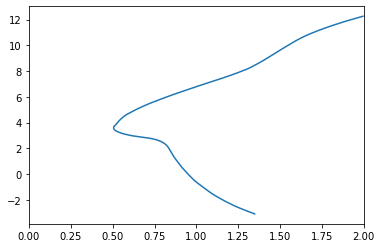

In [6]:
plt.plot(bpmag-rpmag, gmag)
#plt.ylim(21, 12)
plt.xlim(0,2)

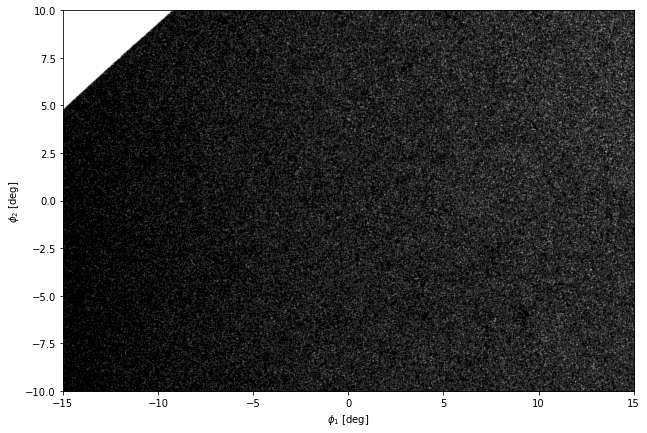

In [7]:
cp_phoenix = coord.SkyCoord(ra=[20.1, 27.9]*u.deg, dec=[-55.3, -42.7]*u.deg, 
                            distance=np.ones(2)*19.1*u.kpc, frame='icrs')

pole_phoenix = gc.pole_from_endpoints(cp_phoenix[0], cp_phoenix[1])

fr_phoenix = gc.GreatCircleICRSFrame(pole=pole_phoenix, rotation=35.5*u.deg)
cpole_phoenix = cp_phoenix.transform_to(fr_phoenix)

ceq_nc = coord.SkyCoord(ra=gaia_data['RA']*u.deg, dec=gaia_data['DEC']*u.deg, distance=np.ones(len(gaia_data))*19.1*u.kpc,
                  pm_ra_cosdec=gaia_data['PMRA']*u.mas/u.yr, pm_dec=gaia_data['PMDEC']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(gaia_data))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(fr_phoenix) #transform into stream coords

ends = [27.9, -42.7, 20.1, -55.3]  
phi1, phi2, R = rotation(ends, gaia_data['RA'], gaia_data['DEC'])

plt.figure(figsize=(15,7))
plt.plot(phi1, phi2, 'k.', ms=1, alpha=0.1)
# plt.plot(c_gc.phi1, c_gc.phi2, 'ro')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-15,15)
plt.ylim(-10,10)
plt.gca().set_aspect('equal')

In [8]:
ceq_nc[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (5.6849834, -30.05875704, 19.1)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (22.58016555, -11.73427212, 0.)>

In [9]:
ind_phi2 = (np.abs(c.phi2)<2*u.deg) & (c.phi1<8*u.deg)
ind_off = (np.abs(c.phi2)<5*u.deg) & (np.abs(c.phi2)>3*u.deg) & (c.phi1<8*u.deg)
ind_pmeq = (gaia_data['PMRA']>1.7) & (gaia_data['PMRA']<2.7) & (gaia_data['PMDEC']>1.2) & (gaia_data['PMDEC']<2.2)
points = np.array([gaia_data['BP_RP'], gaia_data['PHOT_G_MEAN_MAG']]).T
print(points)

[[ 1.8982182 18.923557 ]
 [ 0.675663  18.063189 ]
 [ 1.7848577 16.314531 ]
 ...
 [ 1.1362896 18.430502 ]
 [ 1.0679169 20.243715 ]
 [ 2.8025513 18.94023  ]]


In [10]:
# distance modulus
distance_app = 16.6*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_bprp = bpmag-rpmag + 0.07
i_g = gmag+dm

i_left = i_bprp - 0.15*(i_g/28)**2
i_right = i_bprp + 0.2*(i_g/28)**2

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21) & (poly[:,1]>12)
poly_main = poly[ind]

path_main = mpl.path.Path(poly_main)
ind_cmd = path_main.contains_points(points)

In [11]:
g_min = 16.4
g_max = 17.0
bprp_min = 0.1
bprp_max = 0.5
poly_bhb = np.array([[bprp_min, g_max], [bprp_min, g_min], [bprp_max, g_min], [bprp_max, g_max]])
path_bhb = mpl.path.Path(poly_bhb)
ind_bhb = path_bhb.contains_points(points)
print(len(ind_bhb))

4171786


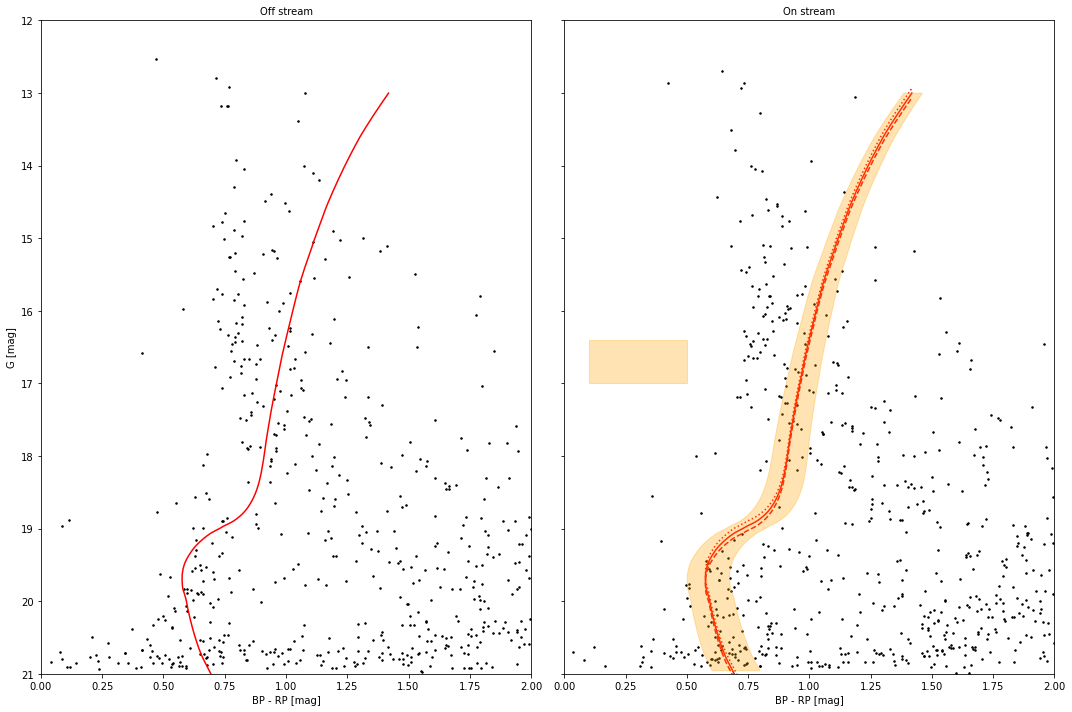

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,10), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(gaia_data['BP_RP'][ind_off & ind_pmeq], gaia_data['PHOT_G_MEAN_MAG'][ind_off & ind_pmeq], 'k.', ms=3, alpha=1)
plt.plot(i_bprp, i_g, 'r-')

plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.title('Off stream', fontsize='medium')
plt.xlim(0,2)
plt.ylim(21,12)

plt.sca(ax[1])
plt.plot(gaia_data['BP_RP'][ind_phi2 & ind_pmeq], gaia_data['PHOT_G_MEAN_MAG'][ind_phi2 & ind_pmeq], 
         'k.', ms=3, alpha=1)
plt.plot(i_bprp, i_g, 'r-')

delta_distance = 0.5*u.kpc
dm_plus = 5*np.log10(((distance_app+delta_distance).to(u.pc)).value) - 5*np.log10((distance_app.to(u.pc)).value)
dm_minus = 5*np.log10((distance_app.to(u.pc)).value) - 5*np.log10(((distance_app-delta_distance).to(u.pc)).value)
plt.plot(i_bprp, i_g+dm_plus, 'r--')
plt.plot(i_bprp, i_g-dm_minus, 'r:')


pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pm = mpl.patches.Polygon(poly_bhb, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlabel('BP - RP [mag]')
plt.title('On stream', fontsize='medium')

plt.tight_layout()



In [13]:
ind_pm = ((c.pm_phi1_cosphi2>1.7*u.mas/u.yr) & (c.pm_phi1_cosphi2<2.5*u.mas/u.yr) & 
                  (c.pm_phi2>-1.2*u.mas/u.yr) & (c.pm_phi2<-0.2*u.mas/u.yr))
ind_mem = ind_pm & ind_cmd
ind_mem_bhb = ind_pm & ind_bhb & (np.abs(c.phi2)<2*u.deg)

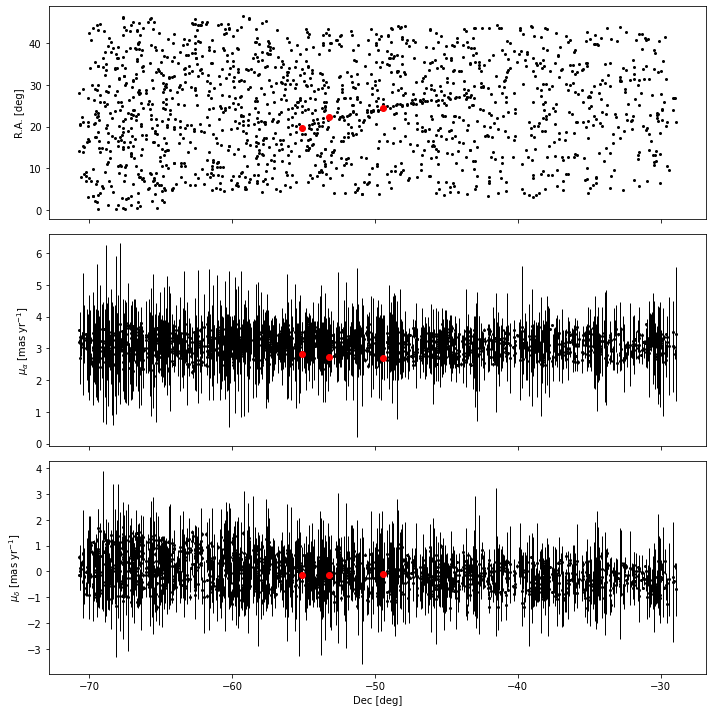

In [14]:
y = [gaia_data['RA'], gaia_data['PMRA'], gaia_data['PMDEC']]
yerr = [(gaia_data['DEC_ERROR']*u.mas).to(u.deg).value, gaia_data['PMRA_ERROR'], gaia_data['PMDEC_ERROR']]
nr = len(y)
ylabels = ['R.A. [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    plt.errorbar(gaia_data['DEC'][ind_mem], y[i][ind_mem], yerr=yerr[i][ind_mem], fmt='o', color='k', ms=2, lw=1)
    plt.errorbar(gaia_data['DEC'][ind_mem_bhb], y[i][ind_mem_bhb], yerr=yerr[i][ind_mem_bhb], fmt='o', color='r')
    plt.ylabel(ylabels[i])

plt.xlabel('Dec [deg]')

plt.tight_layout()

In [15]:
cphoenix = c

[array([ 21.5115205 ,  19.82592685,  19.83026197, ..., -13.24767284,
       -12.39962182, -12.44221367]), array([22.58016555,  4.51052258, 31.16374209, ...,  6.44265333,
       59.1748586 ,  3.6406169 ]), array([-11.73427212,  -4.80608689,  -7.27688298, ...,   1.61636089,
       -36.70582817,  -4.01969832])]
[False False False ... False False False]
9


Text(0.5, 0, '$\\phi_1$ [deg]')

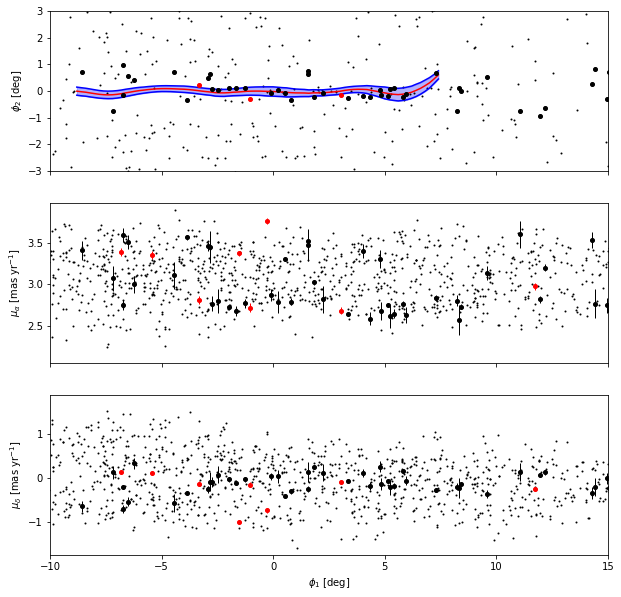

In [25]:
y = [cphoenix.phi2.value, gaia_data['PMRA'], gaia_data['PMDEC']]
print(y)
yerr = [(gaia_data['DEC_ERROR']*u.mas).to(u.deg).value, gaia_data['PMRA_ERROR'], gaia_data['PMDEC_ERROR']]
nr = len(y)

ylabels = ['$\phi_2$ [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_phoenix = ind_pm & ind_cmd
print(ind_phoenix)
ind_phoenix_bhb = ind_pm & ind_bhb
print(len(y[0][ind_phoenix_bhb]))
ind_phi2_phoenix = (np.abs(cphoenix.phi2.value)<1) & (gaia_data['PMRA_ERROR']<0.2)

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    plt.plot(cphoenix.phi1.value[ind_phoenix], y[i][ind_phoenix], 'ko', ms=1)
    plt.errorbar(cphoenix.phi1.value[ind_phoenix & ind_phi2_phoenix], y[i][ind_phoenix & ind_phi2_phoenix], 
                 yerr=yerr[i][ind_phoenix & ind_phi2_phoenix], fmt='o', ms=4, color='k', lw=1)
    plt.errorbar(cphoenix.phi1.value[ind_phoenix_bhb], y[i][ind_phoenix_bhb], 
                 yerr=yerr[i][ind_phoenix_bhb], fmt='o', ms=4, color='r', lw=1)
    plt.ylabel(ylabels[i])
    
    if i==0:
        fi2_map = np.load('model_arrays/phoenix_fi2_map_test{}.npy'.format(0))
        width_map = np.load('model_arrays/phoenix_width_map_test{}.npy'.format(0))
        pp1 = np.load('model_arrays/pp1_full_phoenix_tall.npy')
        pp1 = pp1[:,1:]
        plt.plot(pp1[80], fi2_map[80], c = 'r')
        plt.plot(pp1[80], fi2_map[80]+width_map[80], c = 'b')
        plt.plot(pp1[80], fi2_map[80]-width_map[80], c = 'b')
        plt.fill_between(pp1[80], fi2_map[80]-width_map[80], fi2_map[80]+width_map[80], alpha = 0.3, color= 'b')
        plt.ylim(-3,3)
        plt.xlim(-10,15)

plt.xlabel('$\phi_1$ [deg]')

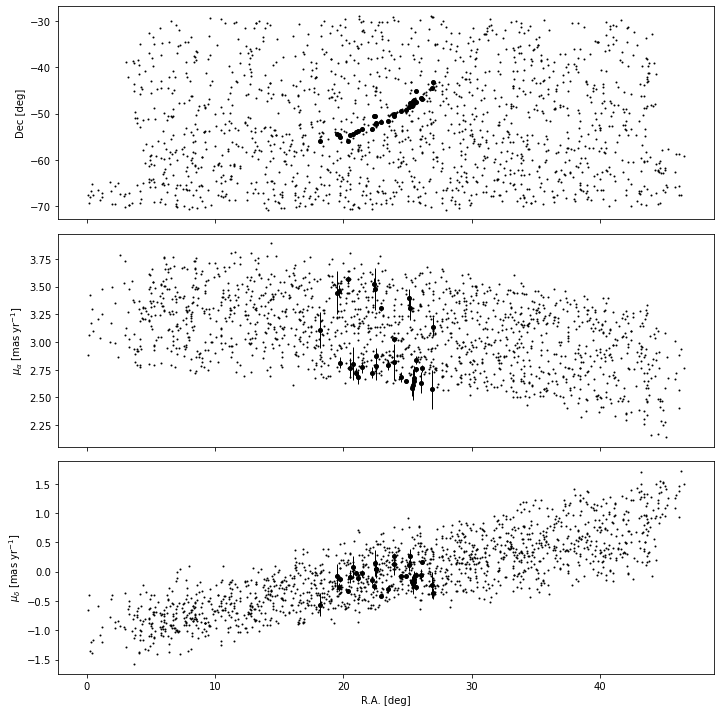

In [23]:
y = [gaia_data['DEC'], gaia_data['PMRA'], gaia_data['PMDEC']]
yerr = [(gaia_data['DEC_ERROR']*u.mas).to(u.deg).value, gaia_data['PMRA_ERROR'], gaia_data['PMDEC_ERROR']]
nr = len(y)
ylabels = ['Dec [deg]', '$\mu_{\\alpha}$ [mas yr$^{-1}$]', '$\mu_{\delta}$ [mas yr$^{-1}$]']

ind_save_phoenix = (ind_pm & (ind_cmd | ind_bhb) & (np.abs(cphoenix.phi2.value)<1) & (gaia_data['PMRA_ERROR']<0.2)
                    & (cphoenix.phi1>-5*u.deg) & (cphoenix.phi1<10*u.deg) & (ceq_nc.ra<27*u.deg))

fig, ax = plt.subplots(nr, 1, figsize=(10,10), sharex=True)

for i in range(nr):
    plt.sca(ax[i])
    
    plt.plot(gaia_data['RA'][ind_phoenix], y[i][ind_phoenix], 'ko', ms=1)
    plt.errorbar(gaia_data['RA'][ind_save_phoenix], y[i][ind_save_phoenix], yerr=yerr[i][ind_save_phoenix], 
                 fmt='o', color='k', ms=4, lw=1)

    plt.ylabel(ylabels[i])

plt.xlabel('R.A. [deg]')

plt.tight_layout()